In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 602M/612M [00:04<00:00, 107MB/s] 
100% 612M/612M [00:04<00:00, 136MB/s]


In [ ]:
ls

gtsrb-german-traffic-sign.zip  kaggle.json  sample_data/


In [ ]:
! unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [ ]:
data_dir = '../content/Meta/'
train_path = '../content/Train/'
test_path = '../content/Test/'
height = 50
width = 50

In [ ]:
classes = {0:'Speed limit (20km/h)',
           1:'Speed limit (30km/h)', 
           2:'Speed limit (50km/h)', 
           3:'Speed limit (60km/h)', 
           4:'Speed limit (70km/h)', 
           5:'Speed limit (80km/h)', 
           6:'End of speed limit (80km/h)', 
           7:'Speed limit (100km/h)', 
           8:'Speed limit (120km/h)', 
           9:'No passing', 
           10:'No passing veh over 3.5 tons', 
           11:'Right-of-way at intersection', 
           12:'Priority road', 
           13:'Yield', 
           14:'Stop', 
           15:'No vehicles', 
           16:'Veh > 3.5 tons prohibited', 
           17:'No entry', 
           18:'General caution', 
           19:'Dangerous curve left', 
           20:'Dangerous curve right', 
           21:'Double curve', 
           22:'Bumpy road', 
           23:'Slippery road', 
           24:'Road narrows on the right', 
           25:'Road work', 
           26:'Traffic signals', 
           27:'Pedestrians', 
           28:'Children crossing', 
           29:'Bicycles crossing', 
           30:'Beware of ice/snow',
           31:'Wild animals crossing', 
           32:'End speed + passing limits', 
           33:'Turn right ahead', 
           34:'Turn left ahead', 
           35:'Ahead only', 
           36:'Go straight or right', 
           37:'Go straight or left', 
           38:'Keep right', 
           39:'Keep left', 
           40:'Roundabout mandatory', 
           41:'End of no passing', 
           42:'End no passing veh > 3.5 tons'}


In [ ]:
batch_size = 150
seed = 42


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


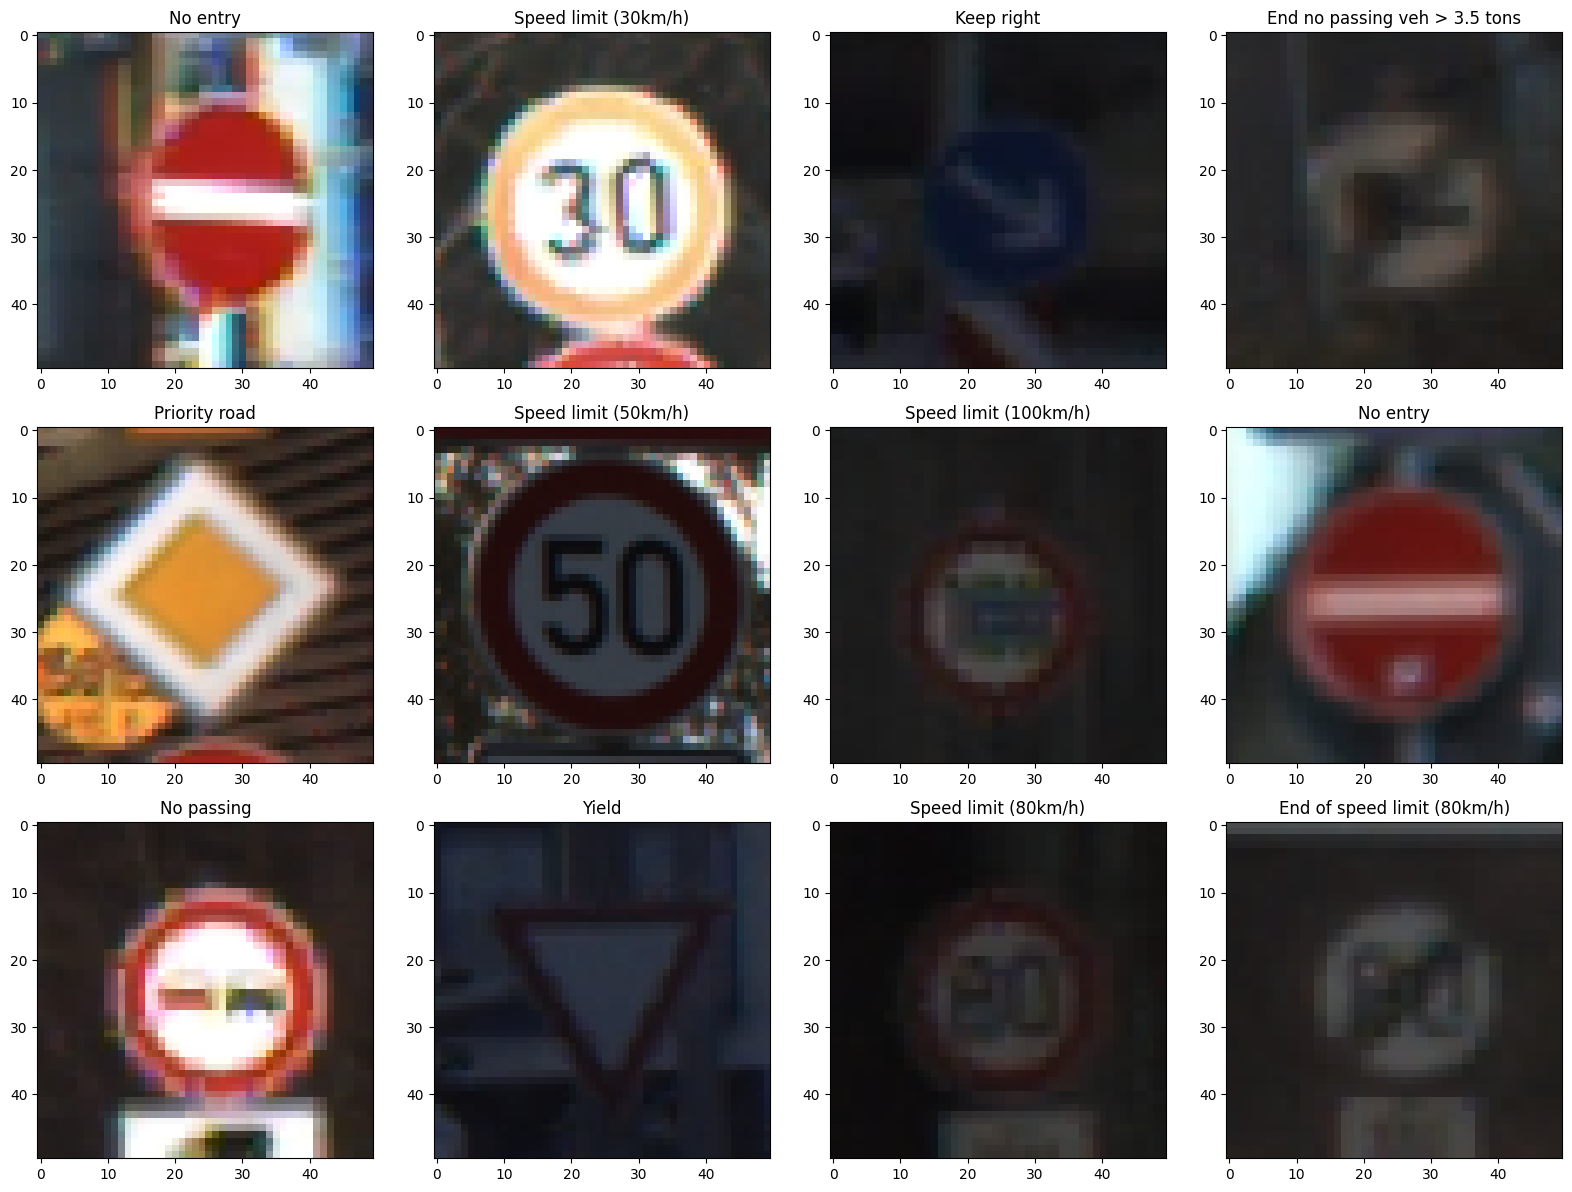

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [ ]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(50,50,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),
    
    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 21, 21, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 64)        3

In [ ]:
alpha=0.01
epochs=25
optim = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))


Epoch 1/25
210/210 [==============================] - 38s 114ms/step - loss: 0.7082 - accuracy: 0.8270 - val_loss: 0.3184 - val_accuracy: 0.9199
Epoch 2/25
210/210 [==============================] - 22s 106ms/step - loss: 0.0669 - accuracy: 0.9805 - val_loss: 0.3828 - val_accuracy: 0.8957
Epoch 3/25
210/210 [==============================] - 22s 106ms/step - loss: 0.0522 - accuracy: 0.9842 - val_loss: 0.4159 - val_accuracy: 0.9028
Epoch 4/25
210/210 [==============================] - 23s 111ms/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 0.5622 - val_accuracy: 0.8897
Epoch 5/25
210/210 [==============================] - 22s 105ms/step - loss: 0.0468 - accuracy: 0.9860 - val_loss: 0.6146 - val_accuracy: 0.8706
Epoch 6/25
210/210 [==============================] - 23s 108ms/step - loss: 0.0403 - accuracy: 0.9882 - val_loss: 0.2817 - val_accuracy: 0.9393
Epoch 7/25
210/210 [==============================] - 22s 105ms/step - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.2904 - val_ac

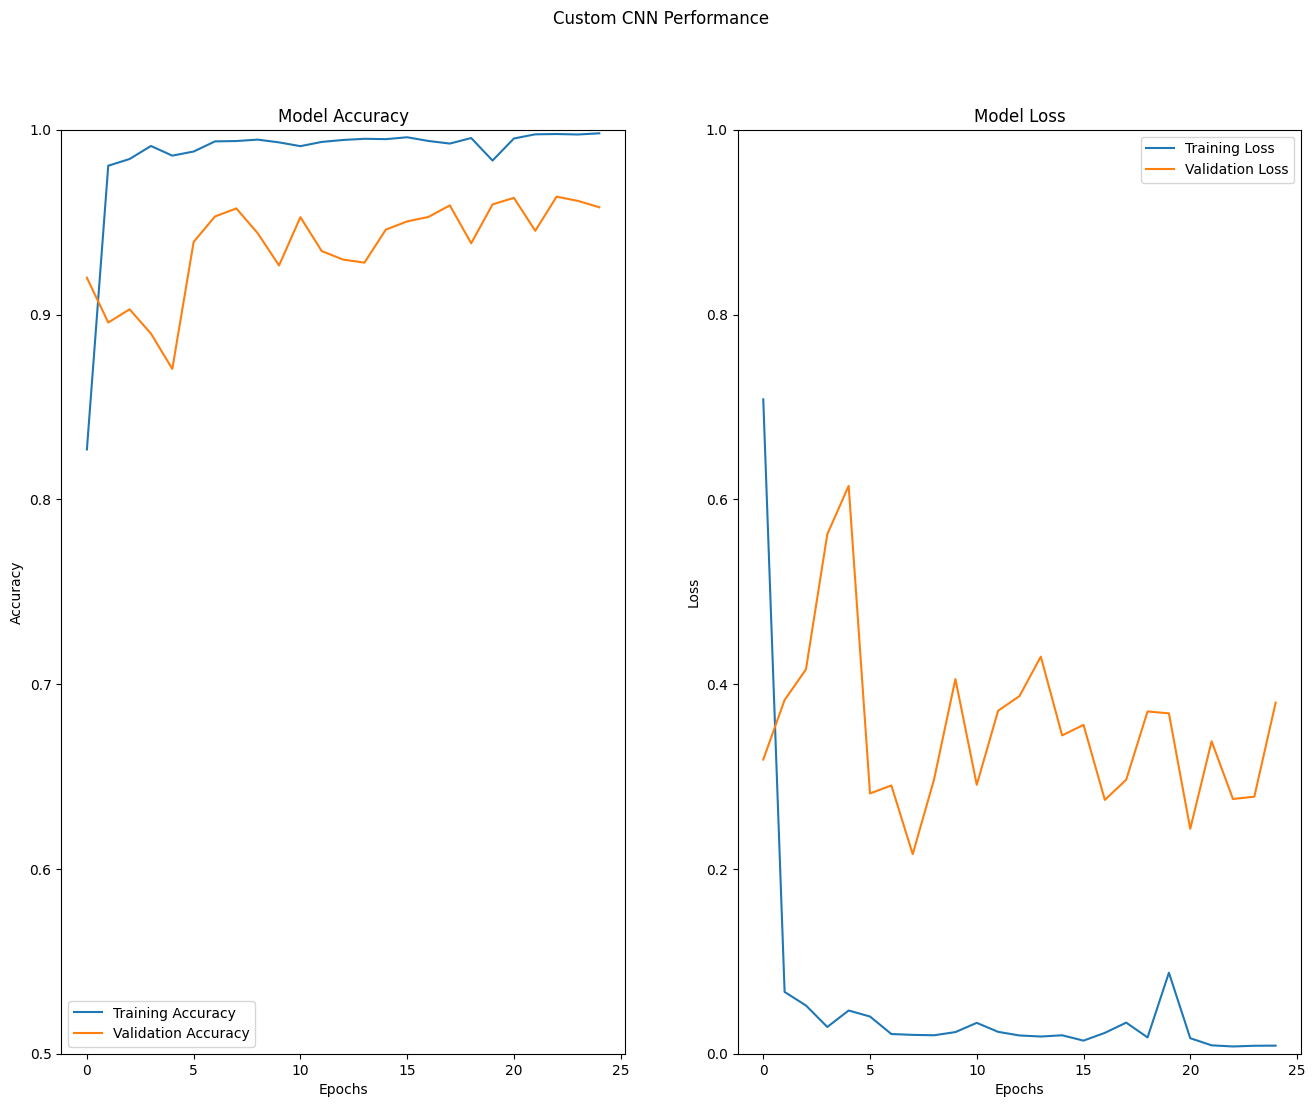

<Figure size 1000x700 with 0 Axes>

In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('Custom CNN Performance')
plt.show()

In [ ]:
model.save("CNN.h5")

In [ ]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
test_df = pd.read_csv('/content/Test.csv')

test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 2s 3ms/step
Test Data accuracy:  86.9912905779889


5/5 [==============================] - 0s 3ms/step


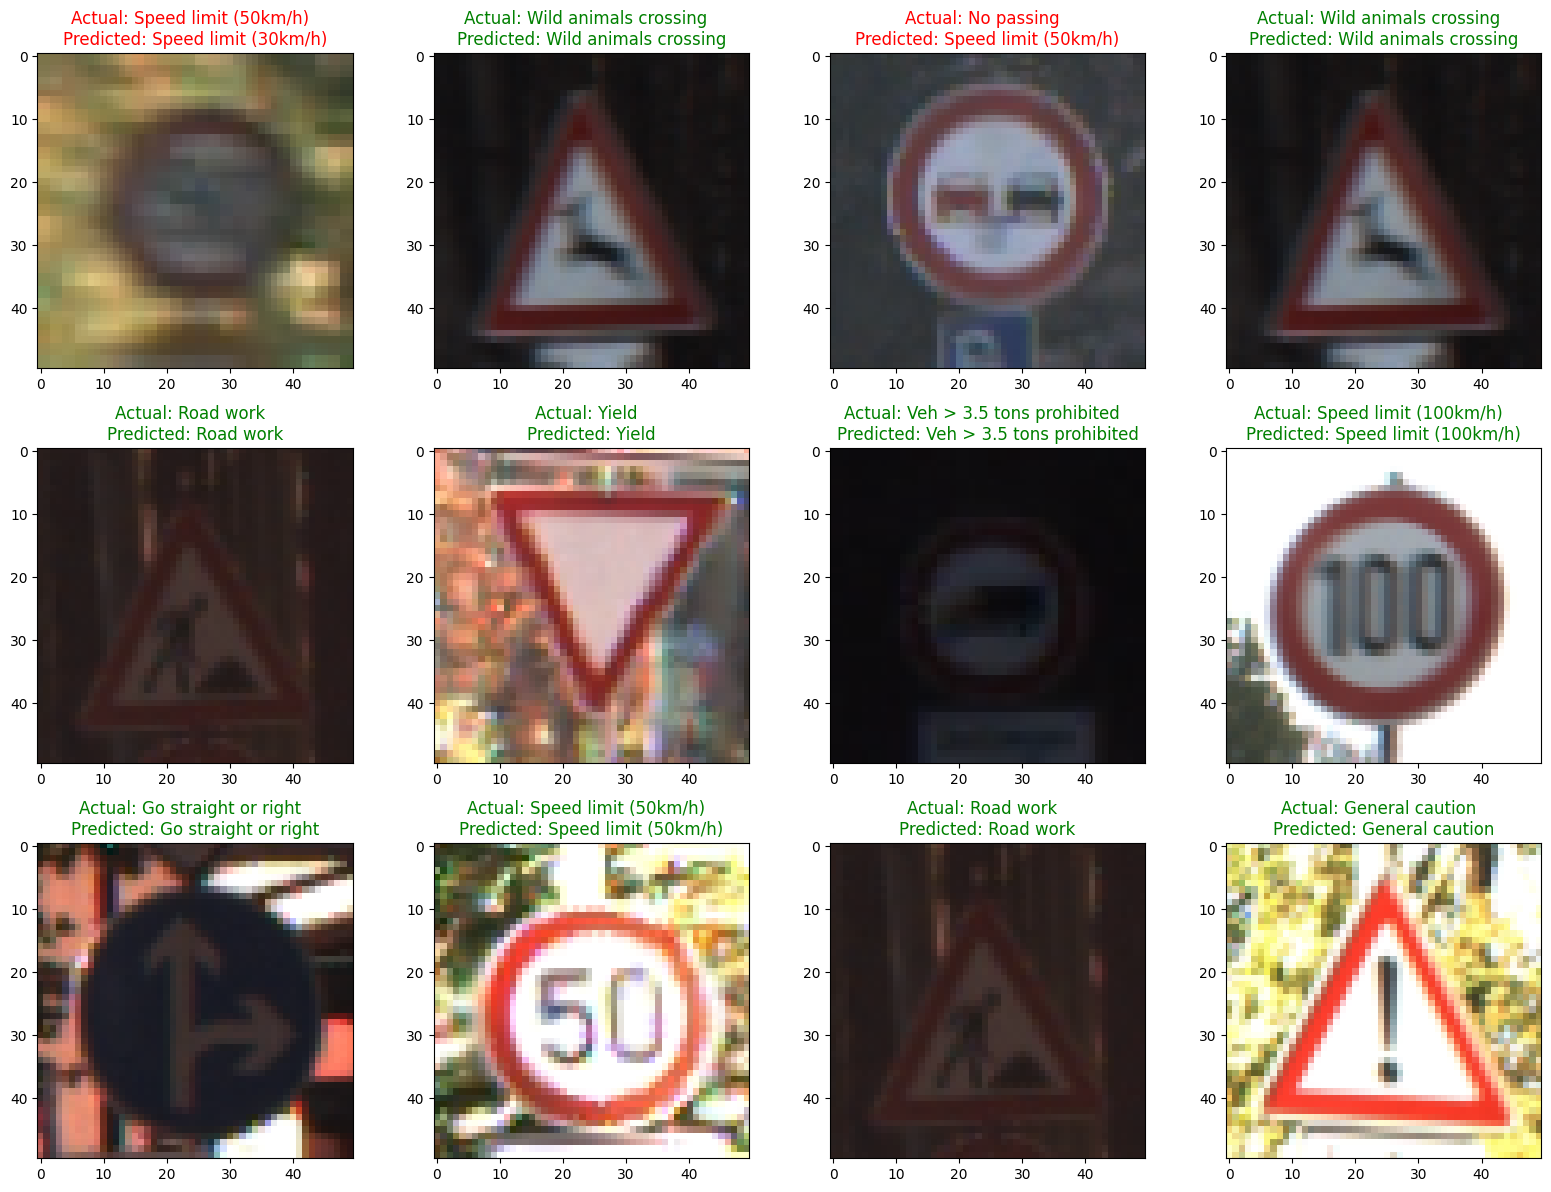

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

In [1]:
#@title VGG Model Implementation


In [ ]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

vgg_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_3 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 43)                22059     
                                                                 
Total params: 20,311,147
Trainable params: 20,310,123
N

In [ ]:
alpha=0.001
epochs=4
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/4
210/210 [==============================] - 52s 189ms/step - loss: 2.2689 - accuracy: 0.3260 - val_loss: 4.1500 - val_accuracy: 0.0774
Epoch 2/4
210/210 [==============================] - 38s 178ms/step - loss: 0.8339 - accuracy: 0.7431 - val_loss: 0.9411 - val_accuracy: 0.6949
Epoch 3/4
210/210 [==============================] - 38s 179ms/step - loss: 0.2631 - accuracy: 0.9281 - val_loss: 0.3938 - val_accuracy: 0.8851
Epoch 4/4
210/210 [==============================] - 37s 177ms/step - loss: 0.1102 - accuracy: 0.9728 - val_loss: 0.2503 - val_accuracy: 0.9324


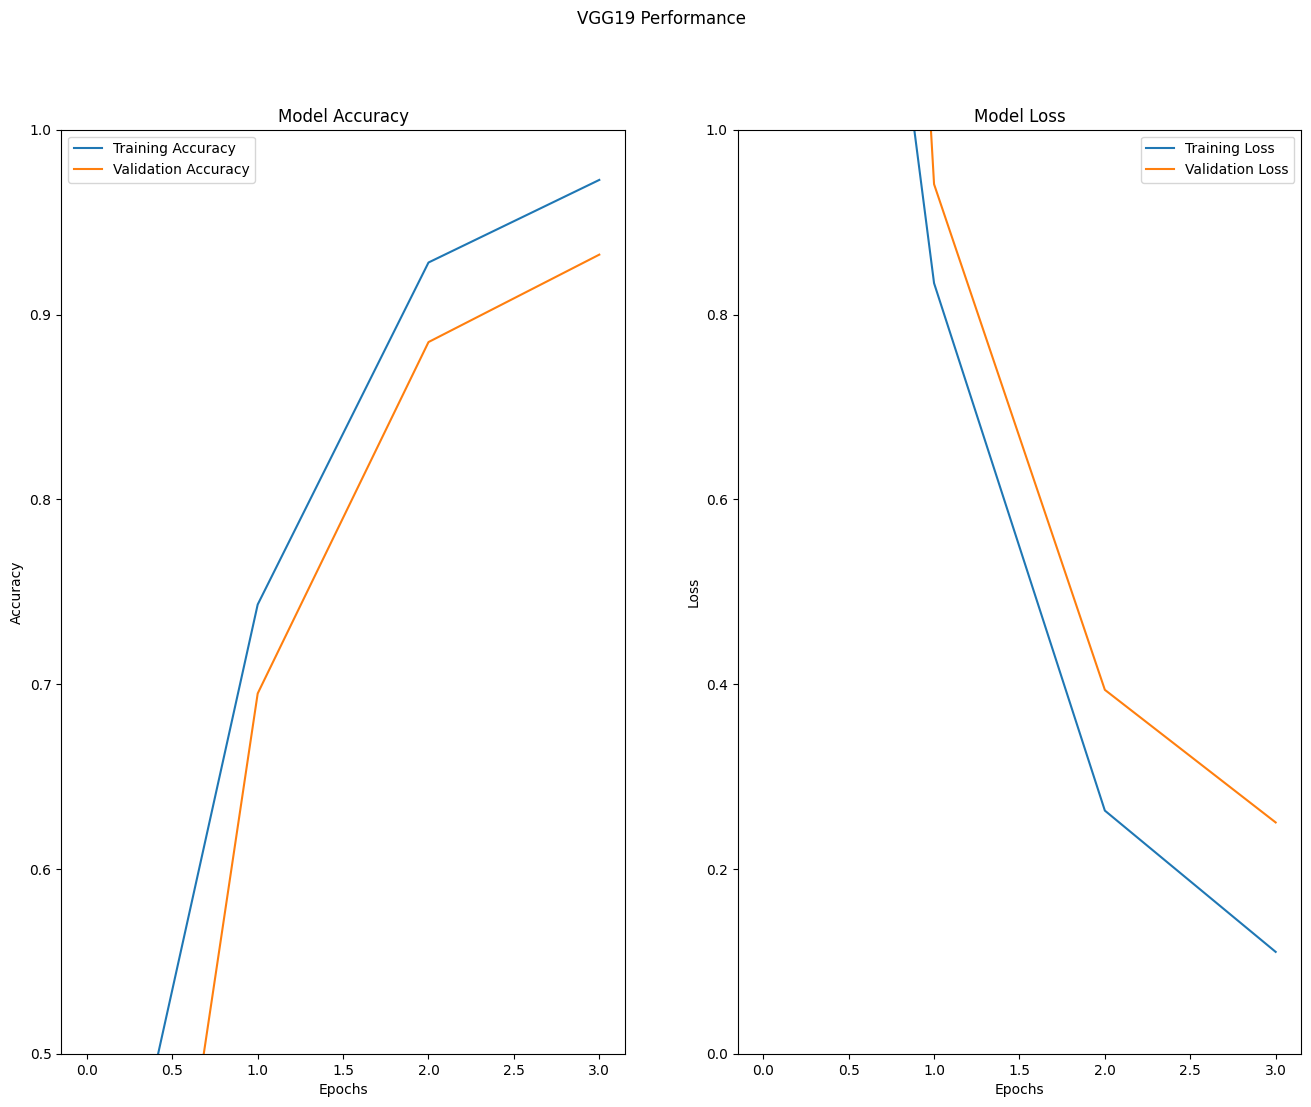

<Figure size 1000x700 with 0 Axes>

In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
pred = vgg_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 7s 16ms/step
Test Data accuracy:  42.652414885193984


In [ ]:
vgg_model.save("VGG.h5")


5/5 [==============================] - 0s 22ms/step


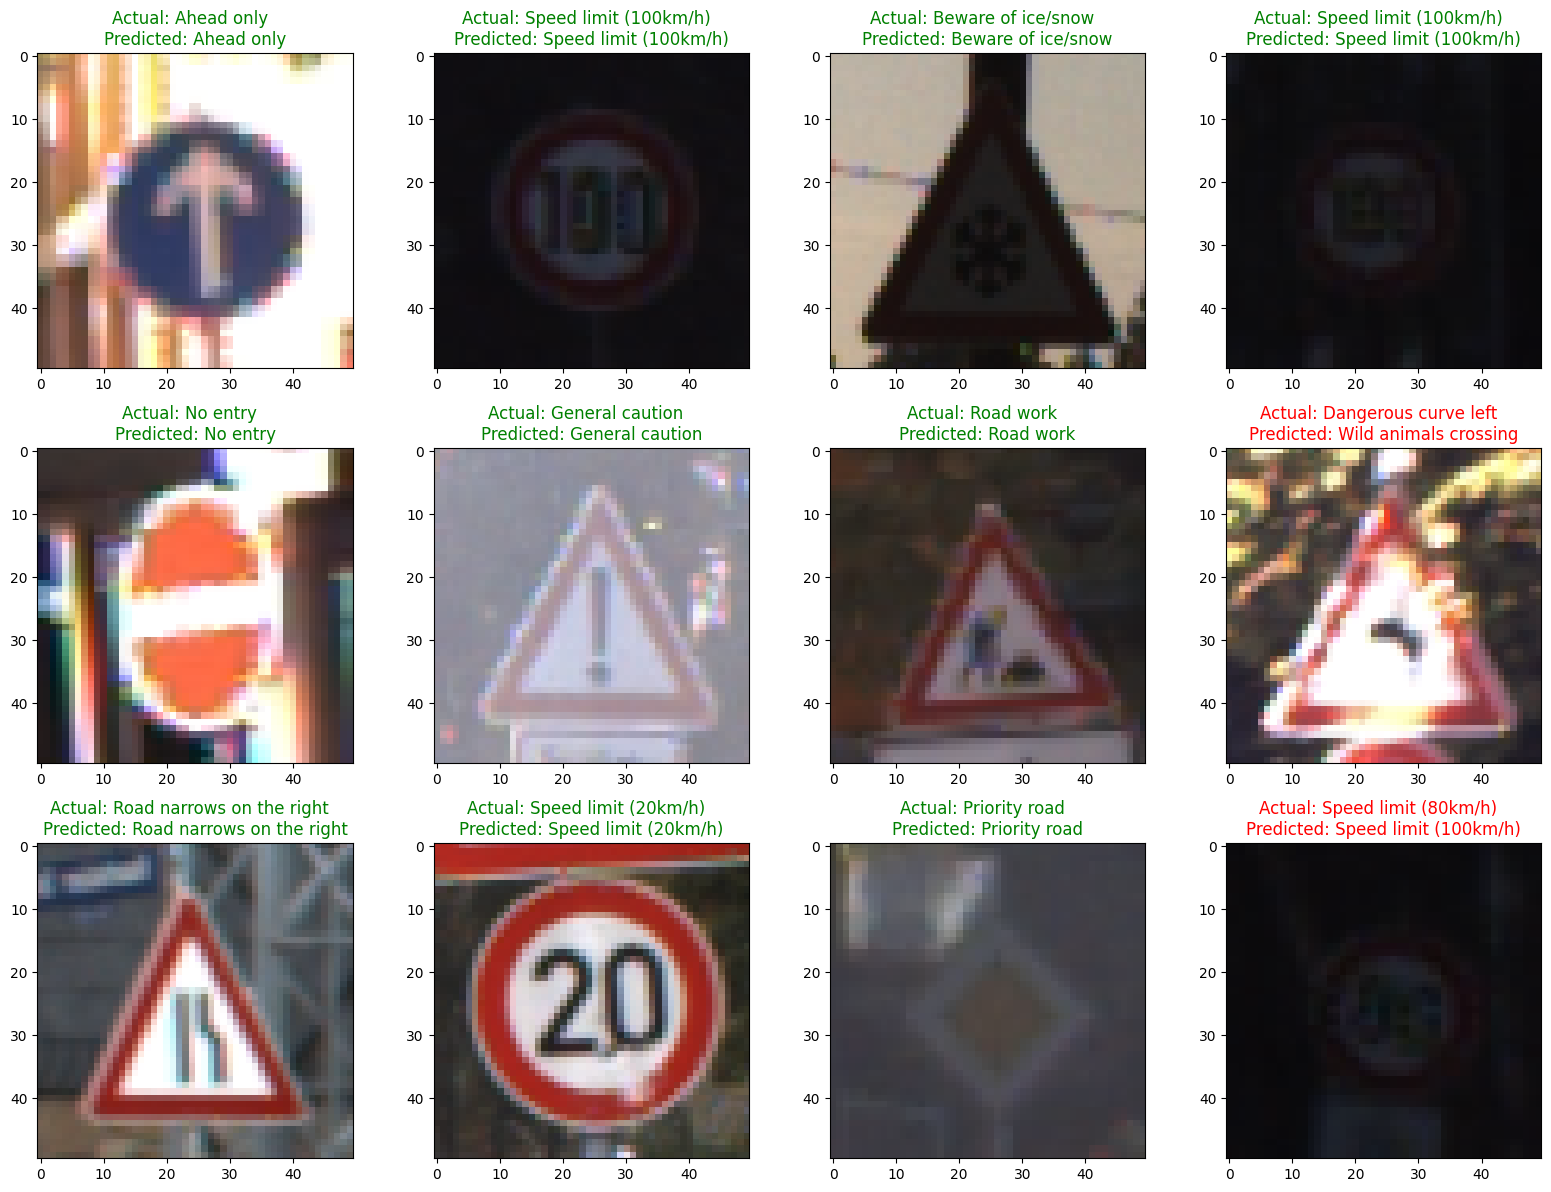

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = vgg_model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()